<a href="https://colab.research.google.com/github/Afix0/BP/blob/main/SDUEBA_003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Dependencies
import numpy as np
import pandas as pd
from collections import Counter
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_text
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder

!pip install subgroups

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.3/274.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.1/286.1 kB 5.1 MB/s eta 0:00:00


In [2]:
#Parameters:
"""
vector_space_dimention  ... dimention of the embedding vector space
n_clusters              ... number of clusters to be found
max_depth               ... maximal depth of the decision tree
test_size               ... size of the test set for training the decision tree
mixed_threashold        ... threshold for classifying a cluster as mixed
"""


vector_space_dimention = 42
n_clusters = 15
max_depth = 4
test_size = 0.2
mixed_threashold = 0.7


In [3]:
from subgroups import datasets

dataset = datasets.load_car_evaluation_csv()
target = ('class', 'acc')

features_raw = pd.DataFrame(data=dataset[['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']])
target_df = pd.DataFrame(data=dataset[['class']])

# Display the first few rows
dataset.head()


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
#Data augemntation sentence creation
features_df = pd.DataFrame()
for column in features_raw.columns:
    split_columns = column.split("_")
    jointed_columns = ' '.join(split_columns)
    features_df[column] = features_raw[column].apply(lambda x: f"{jointed_columns} is {x}")

sentences = []
for i in range(len(features_df)):
    sentence = []
    for word in features_df.iloc[i]:
        sentence.append(word)
    sentences.append(sentence)

In [5]:
#Word2Vec training and clustering
def sentence_embedding(sentence, model):
    word_embeddings = []
    for word in sentence:
        word_embeddings.append(model.wv[word])
    return np.mean(word_embeddings, axis=0)

model = Word2Vec(sentences, min_count=1, vector_size=vector_space_dimention, window=5)
embeddings = np.array([sentence_embedding(sentence, model) for sentence in sentences])
labels_aglomerative_average = AgglomerativeClustering(n_clusters= n_clusters, metric = 'cosine', linkage='average').fit_predict(embeddings)

In [6]:
#Decission tree training
features_classify = features_raw.assign(cluster = labels_aglomerative_average)

encoder = OneHotEncoder()
X = features_classify.drop(columns=['cluster'])
X_encoded = encoder.fit_transform(X)
y = features_classify['cluster']
X_df = pd.DataFrame(X, columns=encoder.get_feature_names_out())


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=test_size, random_state=73, stratify=y)

clf = DecisionTreeClassifier(max_depth=max_depth, random_state=73)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.7138728323699421
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       1.00      0.79      0.89        34
           2       1.00      1.00      1.00        38
           3       0.95      1.00      0.97        36
           4       1.00      1.00      1.00        19
           5       0.00      0.00      0.00        19
           6       0.62      1.00      0.76        21
           7       0.39      1.00      0.56        22
           8       1.00      1.00      1.00        19
           9       0.00      0.00      0.00        22
          10       1.00      1.00      1.00        19
          11       0.30      0.19      0.23        16
          12       0.37      1.00      0.54        21
          13       0.76      1.00      0.86        22
          14       0.00      0.00      0.00        22

    accuracy                           0.71       346
   macro avg       0.56      0.67      0.59       3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
def classify_clusters(data_frame, target_df, mixed_threshold, cluster_labels, frequencies=False):

    cluster_to_class_counts = {}
    for i, label in enumerate(cluster_labels):
        cluster_to_class_counts.setdefault(label, {})
        class_label = target_df['class'][i]
        cluster_to_class_counts[label][class_label] = cluster_to_class_counts[label].get(class_label, 0) + 1

    cluster_classifications = {}
    cluster_frequencies = {}
    for cluster, class_counts in cluster_to_class_counts.items():
        total_count = sum(class_counts.values())
        dominant_class, dominant_count = max(class_counts.items(), key=lambda x: x[1])
        relative_frequency = dominant_count / total_count

        if relative_frequency >= mixed_threshold:
            cluster_classifications[cluster] = dominant_class
        else:
            cluster_classifications[cluster] = 'mixed'

        cluster_frequencies[cluster] = total_count

    if frequencies:
        return dict(sorted(cluster_classifications.items())), dict(sorted(cluster_frequencies.items()))
    else:
        return dict(sorted(cluster_classifications.items()))

classify_clusters(features_df, target_df, mixed_threashold, cluster_labels=labels_aglomerative_average, frequencies = True)

({0: 'mixed',
  1: 'unacc',
  2: 'unacc',
  3: 'unacc',
  4: 'mixed',
  5: 'mixed',
  6: 'mixed',
  7: 'mixed',
  8: 'mixed',
  9: 'mixed',
  10: 'mixed',
  11: 'unacc',
  12: 'mixed',
  13: 'unacc',
  14: 'mixed'},
 {0: 80,
  1: 168,
  2: 192,
  3: 180,
  4: 96,
  5: 96,
  6: 104,
  7: 108,
  8: 96,
  9: 108,
  10: 96,
  11: 80,
  12: 108,
  13: 108,
  14: 108})

In [8]:
def compute_wracc(cluster_label, data_frame, target_df, cluster_labels):

    tp = sum((target_df['class'] == classify_clusters(data_frame, target_df, mixed_threashold, cluster_labels)[cluster_label]) &
             (cluster_labels == cluster_label))

    fp = sum((target_df['class'] != classify_clusters(data_frame, target_df, mixed_threashold, cluster_labels)[cluster_label]) &
             (cluster_labels == cluster_label))

    TP = sum(target_df['class'] == classify_clusters(data_frame, target_df, mixed_threashold, cluster_labels)[cluster_label])
    FP = sum(target_df['class'] != classify_clusters(data_frame, target_df, mixed_threashold, cluster_labels)[cluster_label])

    n = tp + fp
    N = TP + FP

    if N == 0 or n == 0:
        return 0

    return (n / N) * ((tp / n) - (TP / N))

wracc_values = {cluster: compute_wracc(cluster, features_df, target_df, labels_aglomerative_average)
                for cluster in set(labels_aglomerative_average)}

print(wracc_values)


{0: 0.0, 1: 0.029144161522633744, 2: 0.03330761316872428, 3: 0.03122588734567901, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.008669838820301779, 12: 0.0, 13: 0.0031105324074074056, 14: 0.0}


In [9]:
def extract_rules(tree, feature_names, class_names, cluster_classifications, node=0, depth=0, rule=[], rules_list=None, unextractable_clusters=None):

    if rules_list is None:
        rules_list = []
    if unextractable_clusters is None:
        unextractable_clusters = []

    left_child = tree.tree_.children_left[node]
    right_child = tree.tree_.children_right[node]
    threshold = tree.tree_.threshold[node]
    feature = tree.tree_.feature[node]
    value = tree.tree_.value[node]

    if left_child == -1 and right_child == -1:
        class_label = class_names[value.argmax()]
        rules_list.append((class_label, " AND ".join(rule)))
        return rules_list, unextractable_clusters

    if left_child != -1:
        left_rule = rule + [f"{feature_names[feature]} <= {threshold:.2f}"]
        rules_list, unextractable_clusters = extract_rules(tree, feature_names, class_names, cluster_classifications, left_child, depth + 1, left_rule, rules_list, unextractable_clusters)

    if right_child != -1:
        right_rule = rule + [f"{feature_names[feature]} > {threshold:.2f}"]
        rules_list, unextractable_clusters = extract_rules(tree, feature_names, class_names, cluster_classifications, right_child, depth + 1, right_rule, rules_list, unextractable_clusters)

    if depth == 0:
        sorted_rules = sorted(rules_list, key=lambda x: x[0])
        print("Rules for subgroups:")
        extracted_clusters = set()

        for class_label, rule_text in sorted_rules:
            extracted_clusters.add(class_label)
            print(f"Rule for subgroup '{class_label}' ({cluster_classifications[class_label]}): {rule_text}, WRAcc measure: {compute_wracc(cluster_label=class_label, data_frame=features_df, target_df=target_df, cluster_labels=labels_aglomerative_average)}")

        for cluster, classification in cluster_classifications.items():
            if cluster not in extracted_clusters:
                unextractable_clusters.append(cluster)

    return rules_list, unextractable_clusters

rules, unextractable_clusters = extract_rules(clf, list(X_df.columns), list(set(features_classify['cluster'])), cluster_classifications=classify_clusters(features_df, target_df, mixed_threashold, cluster_labels=labels_aglomerative_average))
print(f"Unextractable clusters: {unextractable_clusters}")

Rules for subgroups:
Rule for subgroup '1' (unacc): persons_2 > 0.50 AND lug_boot_med <= 0.50 AND lug_boot_big <= 0.50 AND buying_high <= 0.50, WRAcc measure: 0.029144161522633744
Rule for subgroup '2' (unacc): persons_2 > 0.50 AND lug_boot_med > 0.50, WRAcc measure: 0.03330761316872428
Rule for subgroup '3' (unacc): persons_2 > 0.50 AND lug_boot_med <= 0.50 AND lug_boot_big > 0.50 AND buying_high <= 0.50, WRAcc measure: 0.03122588734567901
Rule for subgroup '3' (unacc): persons_2 > 0.50 AND lug_boot_med <= 0.50 AND lug_boot_big > 0.50 AND buying_high > 0.50, WRAcc measure: 0.03122588734567901
Rule for subgroup '4' (mixed): persons_2 <= 0.50 AND doors_5more > 0.50 AND lug_boot_med > 0.50, WRAcc measure: 0.0
Rule for subgroup '6' (mixed): persons_2 <= 0.50 AND doors_5more <= 0.50 AND lug_boot_small > 0.50 AND persons_4 > 0.50, WRAcc measure: 0.0
Rule for subgroup '7' (mixed): persons_2 <= 0.50 AND doors_5more <= 0.50 AND lug_boot_small <= 0.50 AND lug_boot_big > 0.50, WRAcc measure: 0.0

In [10]:
#Cluster metrics
def calculate_support(data_frame, target_df, mixed_threshold, cluster_labels):

    classifications, frequencies = classify_clusters(data_frame, target_df, mixed_threshold, cluster_labels, frequencies=True)

    total_targets = len(cluster_labels)

    support = sum(freq for cluster, freq in frequencies.items() if cluster not in unextractable_clusters)

    support_percentage = (support / total_targets) * 100
    return support_percentage

support = calculate_support(features_df, target_df, mixed_threashold, cluster_labels=labels_aglomerative_average)
print(f"Overall support of describable subgroups is {support:.2f}%") #Subgroups can be undescribable if they are too small and decission tree cant find the rules for characterization
#Entropy, serendipity TBD - dont know how to do it at the moment

Overall support of describable subgroups is 77.31%


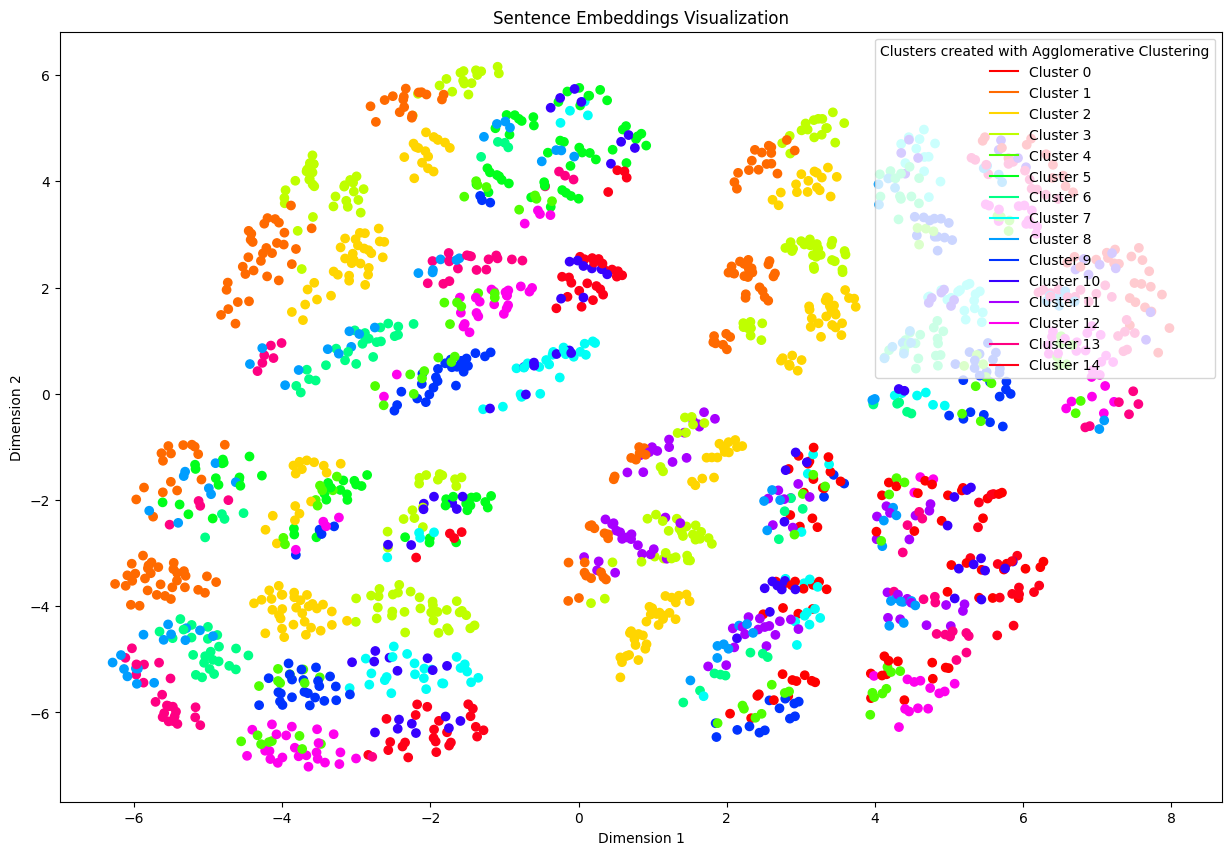

In [11]:
#Clusters visualization
def plot_sentence_embeddings(embeddings, cluster_labels=None, target_labels=None, clustering_method=None):
    plt.figure(figsize=(15, 10))
    tsne = TSNE(n_components=2, random_state= 73, perplexity=300, learning_rate=200, max_iter=1000)
    embeddings_2d = tsne.fit_transform(np.array(embeddings))
    cmap = plt.colormaps['hsv']


    if cluster_labels is not None and target_labels is None:
        n_clusters = len(set(cluster_labels))
        colors = cmap(np.linspace(0, 1, n_clusters))
        handles = [plt.Line2D([], [], color=color) for color in colors]
        labels = [f"Cluster {i}" for i in range(n_clusters)]
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors[cluster_labels])

        plt.legend(handles=handles, labels=labels, title=f"Clusters created with {clustering_method}", loc = "upper right")

    elif target_labels is not None and cluster_labels is None:

        edible_color = 'green'
        poisonous_color = 'red'

        colors = [edible_color if label == 'edible' else poisonous_color for label in target_labels]

        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)
        handles = [plt.Line2D([], [], color=edible_color, label='Edible'), plt.Line2D([], [], color=poisonous_color, label='Poisonous')]

        labels = ['Edible', 'Poisonous']

        plt.legend(handles=handles, labels=labels, title="Classes", loc="upper right")


    else:
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=range(len(sentences)), cmap=cmap)

    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(f"Sentence Embeddings Visualization")
plot_sentence_embeddings(embeddings, cluster_labels=labels_aglomerative_average, clustering_method='Agglomerative Clustering')

In [12]:
from subgroups.quality_measures import WRAcc
from subgroups.quality_measures import WRAccOptimisticEstimate1
from subgroups.algorithms import VLSD

vlsd_model = VLSD(quality_measure = WRAcc(), q_minimum_threshold  = -1, optimistic_estimate = WRAccOptimisticEstimate1(), oe_minimum_threshold = -1, sort_criterion_in_s1 = VLSD.SORT_CRITERION_NO_ORDER, sort_criterion_in_other_sizes = VLSD.SORT_CRITERION_NO_ORDER, vertical_lists_implementation = VLSD.VERTICAL_LISTS_WITH_BITSETS, write_results_in_file = True, file_path = "./vlsd_result.txt")
vlsd_model.fit(dataset, target)

In [13]:
import re
import os

def extract_wracc_from_file(file_path):
    subgroups = []

    if not os.path.exists(file_path):
        print(f"Error: File '{file_path}' not found.")
        return []

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            match = re.search(r"Description: (.*?);.*?WRAcc\s*=\s*([+-]?\d*\.?\d+)", line)
            if match:
                description = match.group(1).strip()
                try:
                    wracc = float(match.group(2))
                    subgroups.append((description, wracc))
                except ValueError:
                    print(f"Warning: Could not convert WRAcc value '{match.group(2)}' to float.")

    if not subgroups:
        print("Warning: No valid WRAcc values found in file.")

    return subgroups

def find_top_subgroups(file_path, top_n=1):
    subgroups = extract_wracc_from_file(file_path)
    sorted_subgroups = sorted(subgroups, key=lambda x: x[1], reverse=True)
    return sorted_subgroups[:top_n] if subgroups else []

file_path = "./vlsd_result.txt"

top_subgroups = find_top_subgroups(file_path, top_n=5)

if top_subgroups:
    for desc, wracc in top_subgroups:
        print(f"Subgroup: {desc}, WRAcc: {wracc}")
else:
    print("No valid subgroups found.")


Subgroup: [buying = 'low', lug_boot = 'med', maint = 'high', persons = 'more', safety = 'high'], Target: class = 'acc', WRAcc: 6.430041152263376
Subgroup: [buying = 'low', lug_boot = 'med', maint = 'low', persons = 'more', safety = 'med'], Target: class = 'acc', WRAcc: 6.430041152263376
Subgroup: [buying = 'low', lug_boot = 'med', maint = 'med', persons = 'more', safety = 'med'], Target: class = 'acc', WRAcc: 6.430041152263376
Subgroup: [buying = 'low', doors = '2', lug_boot = 'big', persons = '4', safety = 'high'], Target: class = 'acc', WRAcc: 6.430041152263376
Subgroup: [buying = 'low', doors = '2', lug_boot = 'big', persons = 'more', safety = 'high'], Target: class = 'acc', WRAcc: 6.430041152263376
